In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import os

import data_loader
import utils

In [2]:
class Decoder(nn.Module):
    def __init__(self, c_in, scale):
        super(Decoder, self).__init__()

        assert scale in [1, 2, 4, 8]

        if scale >= 1:
            self.conv1 = Conv2dBN(c_in, c_in, 3, padding=1)
        if scale >= 4:
            self.conv2 = Conv2dBN(c_in, c_in, 3, padding=1)
        if scale >= 8:
            self.conv3 = Conv2dBN(c_in, c_in, 3, padding=1)

        self.scale = scale

    def forward(self, x):
        if self.scale >= 1:
            x = self.conv1(x)
            if self.scale == 1:
                return x

        if self.scale >= 2:
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)

        if self.scale >= 4:
            x = self.conv2(x)
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)

        if self.scale >= 8:
            x = self.conv3(x)
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)

        return x

In [3]:
class FSModule(nn.Module):
    def __init__(self, cv, cu):
        super(FSModule, self).__init__()

        self.conv1 = Conv2dBN(cv, cu, 1)
        self.conv2 = Conv2dBN(cv, cu, 1)

    def forward(self, v, u):
        x = self.conv1(v)
        r = torch.mul(x, u)
        k = self.conv2(v)
        z = k / (1 + torch.exp(-r))
        return z

In [4]:
class Conv2dBN(nn.Module):
    def __init__(self, c_in, c_out, filter_size, stride=1, padding=0, **kwargs):
        super(Conv2dBN, self).__init__()
        self.conv = nn.Conv2d(c_in, c_out, filter_size, stride=stride, padding=padding, **kwargs)
        self.bn = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [5]:
class FarSegNet(nn.Module):
    def __init__(self, num_classes = 1, num_feature = 256, pretrained = False, ignore_index = 500):
        super(FarSegNet, self).__init__()
        
        self.num_classes = num_classes
        self.num_feature = num_feature
        self.ignore_index = ignore_index # ignore losses of this class
        self.EPS = 1e-5
        self.current_step = 0
        self.annealing_step = 10000
        self.focal_factor = 2
        self.focal_z = 1.0
        
        self.backbone = torchvision.models.resnet50(pretrained=True)
        self.backbone_layer_c2 = nn.Sequential(*list(self.backbone.children())[:5])
        self.backbone_layer_c3 = list(self.backbone.children())[5]
        self.backbone_layer_c4 = list(self.backbone.children())[6]
        self.backbone_layer_c5 = list(self.backbone.children())[7]
        
        self.conv_c6 = nn.Conv2d(2048, num_feature, 1)
        self.conv_c5 = nn.Conv2d(2048, num_feature, 1)
        self.conv_c4 = nn.Conv2d(1024, num_feature, 1)
        self.conv_c3 = nn.Conv2d(512, num_feature, 1)
        self.conv_c2 = nn.Conv2d(256, num_feature, 1)

        self.fs5 = FSModule(num_feature, num_feature)
        self.fs4 = FSModule(num_feature, num_feature)
        self.fs3 = FSModule(num_feature, num_feature)
        self.fs2 = FSModule(num_feature, num_feature)

        self.up5 = Decoder(num_feature, 8)
        self.up4 = Decoder(num_feature, 4)
        self.up3 = Decoder(num_feature, 2)
        self.up2 = Decoder(num_feature, 1)

        self.classify = nn.Conv2d(num_feature, num_classes, 3, padding=1)
    
    def forward(self, x, label = None):
        c2 = self.backbone_layer_c2(x)
        c3 = self.backbone_layer_c3(c2)
        c4 = self.backbone_layer_c4(c3)
        c5 = self.backbone_layer_c5(c4)
        c6 = F.adaptive_avg_pool2d(c5, (1, 1))
        u = self.conv_c6(c6)
        
        p5 = self.conv_c5(c5)
        p4 = (self.conv_c4(c4) + F.interpolate(p5, scale_factor = 2)) / 2.
        p3 = (self.conv_c3(c3) + F.interpolate(p4, scale_factor = 2)) / 2.
        p2 = (self.conv_c2(c2) + F.interpolate(p3, scale_factor = 2)) / 2.
        
        z5 = self.fs5(p5, u)
        z4 = self.fs4(p4, u)
        z3 = self.fs3(p3, u)
        z2 = self.fs2(p2, u)

        o5 = self.up5(z5)
        o4 = self.up4(z4)
        o3 = self.up3(z3)
        o2 = self.up2(z2)
        
        x = (o5 + o4 + o3 + o2) / 4.
        x = F.interpolate(x, scale_factor = 4, mode = "bilinear", align_corners = True)
        logit = self.classify(x)
        
        if self.training:
            return self._get_loss(logit, label), self._get_miou(logit, label)
        else:
            probs = torch.sigmoid(logit)
            preds = (probs > 0.5).int()
            return probs, preds
        
    def _get_loss(self, logit, label):

        logit, label = logit.flatten(), label.flatten()
        loss = nn.BCEWithLogitsLoss(reduction='none')(logit, label)

        probs = torch.sigmoid(logit) # probability
        p = ((1-label) + (-1)**(1+label)*probs).squeeze() # label should be 0 or 1

        z = torch.pow(1.0 - p, self.focal_factor)
        z = self.focal_z * z

        if self.current_step < self.annealing_step:
            z = z + (1 - z) * (1 - self.current_step / self.annealing_step)
        self.current_step += 1

        loss = z * loss
        avg_loss = torch.mean(loss)
        return avg_loss

    def _get_miou(self, logit, label):
        
        miou_sum, miou_count = 0, 0
        for batch_idx in range(label.shape[0]):
            pred_one = (torch.sigmoid(logit[batch_idx].flatten()) > 0.5).int()
            label_one = label[batch_idx].flatten()
            intersection = (pred_one * label_one).sum()
            union = pred_one.sum() + label_one.sum()
            
            miou_sum += intersection / union
            miou_count += 1
            
        return miou_sum / miou_count

In [6]:
net = FarSegNet().cuda()

In [7]:
x = torch.rand((4, 3, 256 ,256)).cuda()
label = torch.ones((4, 1, 256 ,256)).cuda()    
net(x, label)

(tensor(0.7914, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1405, device='cuda:0'))

## Train

In [8]:
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select2_parts_16/"
INPUT_SIZE, OUTPUT_SIZE = 256, 256
BATCH_SIZE = 4
EPOCH_NUM = 60000
LR = 0.007

In [9]:
train_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, 'train')
val_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, 'val')

train dataset set: 7056 pairs
val dataset set: 224 pairs


In [10]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FarSegNet().to(device)

In [12]:
optimizer = optim.SGD(params = net.parameters(), lr=LR, momentum=0.9, weight_decay=1e-4)

In [13]:
writer = SummaryWriter(comment="tensorboard_log{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now()))

In [14]:
def update_lr_poly(initial_lr, step, max_step, power):
    return (1-step/max_step)**power

In [ ]:
global_step = 0
for epoch in range(EPOCH_NUM):
    net.train()
    
    timer, counter = utils.Timer(), utils.Counter()
    timer.start()
    for step, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        reader_time = timer.elapsed_time()

        loss, miou = net(img, label)
        optimizer.zero_grad()
#         net.backbone.fc.weight.retain_grad()
#         net.backbone.fc.bias.retain_grad()
        loss.backward()
        optimizer.step()
        
        loss = float(loss)
        batch_time = timer.elapsed_time()
        counter.append(loss=loss, miou=miou, reader_time=reader_time, batch_time=batch_time)
        eta = utils.calculate_eta(len(train_loader) - step, counter.batch_time)
        print(f"[epoch={epoch + 1}/{EPOCH_NUM}] "
                  f"step={step + 1}/{len(train_loader)} "
                  f"loss={loss:.4f}/{counter.loss:.4f} "
                  f"miou={miou:.4f}/{counter.miou:.4f} "
                  f"batch_time={counter.batch_time:.4f} "
                  f"reader_time={counter.reader_time:.4f} "
                  f"| ETA {eta}",
                  end="\r",
                  flush=True)
        if global_step % 200 == 0:
            writer.add_scalar("Loss", float(loss), global_step=global_step)
            writer.add_scalar("miou", float(miou), global_step=global_step)
            writer.add_scalar("learning_rate", optimizer.param_groups[0]['lr'], global_step = global_step)
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                try:
                    writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                except:
                    pass
    #                 print(tag)
    #                 print(value.shape, value.dtype)

            net.eval()
            with torch.no_grad():
                probs, preds = net(img, label)
            writer.add_images('image', img, global_step)
            writer.add_images('label/true', label, global_step)
            writer.add_images('label/pred_0.5', preds, global_step)
            net.train()
        global_step += 1
        writer.flush()
        
    print()
    if epoch % 5 != 0:
        if os.path.exists('checkpoints/farseg_epoch{}_global_step{}.pth'.format(epoch-4, global_step)):
            os.remove('checkpoints/farseg_epoch{}_global_step{}.pth'.format(epoch-4, global_step))
    torch.save(net.state_dict(), 'checkpoints/farseg_epoch{}_global_step{}.pth'.format(epoch+1, global_step))
    timer.restart()
    optimizer.param_groups[0]['lr'] = update_lr_poly(LR, epoch, EPOCH_NUM, 0.9)

In [22]:
1 & 2

0

In [28]:
img, lbl = next(iter(train_loader))
net.eval()
tt = net(img.cuda(), lbl.cuda())

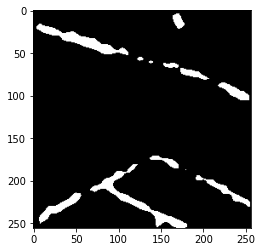

In [29]:
pp = torch.cat([tt[1][0]]*3).permute(1, 2, 0)
plt.imshow((pp*255).cpu())

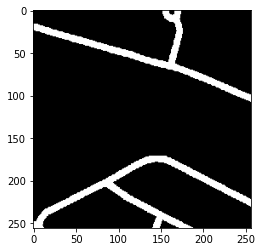

In [30]:
lbl_img = torch.cat([lbl[0]]*3).permute(1, 2, 0)
lbl_img.shape
plt.imshow(lbl_img)